# SOM using Python

__Source:__ https://visualstudiomagazine.com/articles/2019/01/01/self-organizing-maps-python.aspx

Adaptation of the above code to the 6-gaussians dataset used in the TME course.


Loading data into memory 

Constructing a  15 x 15  SOM from the data
step =  0
step =  500
step =  1000
step =  1500
step =  2000
step =  2500
step =  3000
step =  3500
step =  4000
step =  4500
SOM construction complete 

Constructing U-Matrix from SOM
U-Matrix constructed 



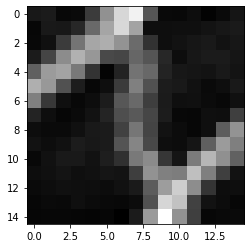

Associating each data label to one map node 


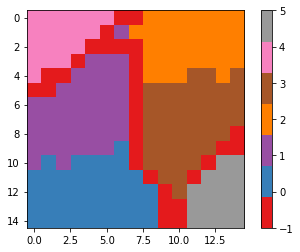

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Function to locate the "closest node" in the SOM map
# for element of index "t" in the dataset. 
def closest_node(data, t, map, m_rows, m_cols):
    """Returns (row,col) of map node closest to data[t]"""
    
    result = (0,0)
    small_dist = 1.0e20
    for i in range(m_rows):
        for j in range(m_cols):
            ed = euc_dist(map[i][j], data[t])
            if ed < small_dist:
                small_dist = ed
                result = (i, j)
    return result

# Euclidean distance between two vectors in parameter space
def euc_dist(v1, v2):
    return np.linalg.norm(v1 - v2) 

# Manhattan distance between two vectors in parameter space
def manhattan_dist(r1, c1, r2, c2):
    return np.abs(r1-r2) + np.abs(c1-c2)

# Determine most common value in a list. Used to 
# determine the label of a neuron by finding its most
# common response in a list of labels
def most_common(lst, n):
    # lst is a list of values 0 . . n
    if len(lst) == 0: return -1
    counts = np.zeros(shape=n, dtype=np.int)
    for i in range(len(lst)):
        counts[lst[i]] += 1
    return np.argmax(counts)

# ==================================================================

# 0. get started
np.random.seed(1)
Dim = 3                 # Number of features
Ntypes = 6              # Number of classes
Rows = 15; Cols = 15    # Size of SOM map
RangeMax = Rows + Cols  
LearnMax = 0.5
StepsMax = 5000

# 1. load data from file
print("\nLoading data into memory \n")
data_file = "6-gaussianes.txt"
data_x = np.loadtxt(data_file, delimiter=",", usecols=range(0,3),
         dtype=np.float64)
data_y = np.loadtxt(data_file, delimiter=",", usecols=[3],
         dtype=np.int)
# option: normalize data  

# 2. construct and training the SOM
print("Constructing a ",Rows,"x",Cols," SOM from the data")
map = np.random.random_sample(size=(Rows,Cols,Dim))
for s in range(StepsMax):
    if s % (StepsMax/10) == 0: print("step = ", str(s))
    pct_left = 1.0 - ((s * 1.0) / StepsMax)
    curr_range = (int)(pct_left * RangeMax)
    curr_rate = pct_left * LearnMax

    t = np.random.randint(len(data_x))
    (bmu_row, bmu_col) = closest_node(data_x, t, map, Rows, Cols)
    for i in range(Rows):
        for j in range(Cols):
            if manhattan_dist(bmu_row, bmu_col, i, j) < curr_range:
                map[i][j] = map[i][j] + curr_rate * \
                            (data_x[t] - map[i][j])
print("SOM construction complete \n")

# 3. construct U-Matrix
print("Constructing U-Matrix from SOM")
u_matrix = np.zeros(shape=(Rows,Cols), dtype=np.float64)
for i in range(Rows):
    for j in range(Cols):
        v = map[i][j]  # a vector 
        sum_dists = 0.0; ct = 0

        if i-1 >= 0:    # above
            sum_dists += euc_dist(v, map[i-1][j]); ct += 1
        if i+1 <= Rows-1:   # below
            sum_dists += euc_dist(v, map[i+1][j]); ct += 1
        if j-1 >= 0:   # left
            sum_dists += euc_dist(v, map[i][j-1]); ct += 1
        if j+1 <= Cols-1:   # right
            sum_dists += euc_dist(v, map[i][j+1]); ct += 1

        u_matrix[i][j] = sum_dists / ct
print("U-Matrix constructed \n")

# display U-Matrix
plt.imshow(u_matrix, cmap='gray')  # black = close = clusters
plt.show()

# 4. because the data has labels, another possible visualization:
# associate each data label with a map node
print("Associating each data label to one map node ")
mapping = np.empty(shape=(Rows,Cols), dtype=object)
for i in range(Rows):
    for j in range(Cols):
        mapping[i][j] = []

for t in range(len(data_x)):
    (m_row, m_col) = closest_node(data_x, t, map, Rows, Cols)
    mapping[m_row][m_col].append(data_y[t])

label_map = np.zeros(shape=(Rows,Cols), dtype=np.int)
for i in range(Rows):
    for j in range(Cols):
        label_map[i][j] = most_common(mapping[i][j], Ntypes)

plt.imshow(label_map, cmap=plt.cm.get_cmap('Set1', Ntypes+1))
plt.colorbar()
plt.show()

### Use map for classification

In [2]:
total= 0
correct= 0
for i in range(len(data_x)):
    
    # Select winning neuron
    row, col = closest_node(data_x, i, map, Rows, Cols)
    
    # Collect classification from label map and compare
    if data_y[i]==label_map[row][col]:
        correct+=1
    total+=1
    
print("Total:  ", total)
print("Correct: {:d} ({:.2f}%)".format(correct,100.*correct/total))

Total:   4998
Correct: 4896 (97.96%)


### Confusion matrix

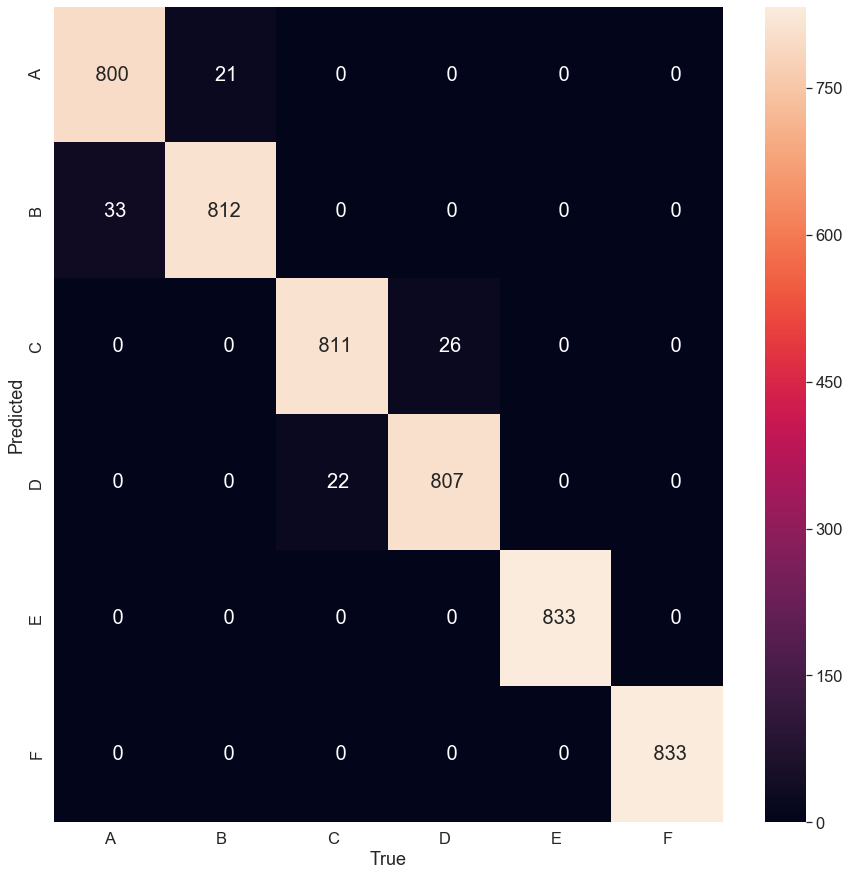

In [3]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate list of true-predicted letter codes
true= data_y

pred= []
for i in range(len(data_x)):
    
    # Select winning neuron
    row, col = closest_node(data_x, i, map, Rows, Cols)
    
    # Collect classification from label
    pred.append(label_map[row][col])

# Generate confusion matrix
CM= confusion_matrix(pred,true)

# Plot heatmap
df_cm = pd.DataFrame(CM, range(6), range(6))
t_labels= [ chr(val+65) for val in range(0,6)]

plt.figure(figsize=(15,15))

sn.set(font_scale=1.5) # for label size
HM= sn.heatmap(df_cm, annot=True, annot_kws={"size":20}, fmt="4d")
HM.set_yticklabels(t_labels)
HM.set_xticklabels(t_labels)

# Patch to avoid cut in top/bottom; see https://github.com/mwaskom/seaborn/issues/1773
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()
